In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# new packages
import statsmodels as sm
import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [10]:
# we will need to install these packages manually
!pip3 install arch
!pip3 install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.3 MB/s eta 0:00:00


In [22]:
# importing models
from arch import arch_model
from pmdarima import auto_arima

# auto_arima calls a function by its old name, spitting out a warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
!pip install --upgrade pmdarima scikit-learn

# **SARIMA for Time Series Modeling**

Use when your data is indexed over time.

In [39]:
# my data set
stock_symbol = 'NVDA'
start_date = '2024-01-01'
end_date = '2025-01-31'

data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


I have chosen Nvidia stock as a sample time series data set. The models I will use will work for any data indexed over time.

The variable `data` is a data frame. We can see what our data looks like below:

In [40]:
display(data.head())

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2024-01-02,48.154346,49.281026,47.581511,49.230042,411254000
2024-01-03,47.555515,48.170339,47.306585,47.471539,320896000
2024-01-04,47.984398,48.486255,47.494535,47.753461,306535000
2024-01-05,49.083080,49.532953,48.292304,48.448262,415039000
2024-01-08,52.238182,52.260179,49.464970,49.497962,642510000


I will be considering the closing price, which is just the price of the stock at the end of the trading day, 4:00 pm EST. We can now plot our time series data.

* Note that we are using two brackets in `data[['Close']]` because we have multi-indexed columns. This is because the `yfinance` package structures the data in such a way that allows us to compare multiple stocks to each other.

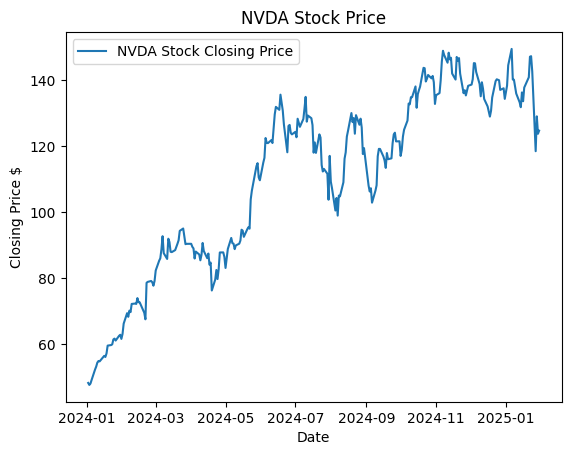

In [41]:
plt.plot(data.index, data[['Close']], label=f'{stock_symbol} Stock Closing Price')
plt.title(f'{stock_symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price $')
plt.legend()
plt.show()

# **Pre-Processing**

The `S` in `SARIMA` refers to seasonality. To model a time series, it is important to understand the seasonal period.

# Seasonal Decompose

**Seasonality** refers to changes in a time series occuring within fixed time intervals. Using the `statsmodel` package, we can split our time series into a trend, seasonality, and residuals component. Before we do that, there are a few things to note.

- `seasonal_decompose` asks us to specify what kind of model we are using: 'additive' or 'multiplicative'. This just means if the function should assume our model is the sum of trend $T_t$, seasonal $S_t$, and residual $R_t$ components or the product of them. You would use additive if the seasonal fluctuations seem constant over time and you would use multiplicative if the seasonal fluctuations seem to depend on the trend.

$$
\text{Additive}: Y_t = T_t + S_t + R_t \\
\text{Multiplicative}: Y_t = T_t \times S_t \times R_t
$$

- In an additive model, we would expect our residuals to behave like a white noise. In a multiplicative model, we would expect our residuals to be close to 1.

You also need to specify a seasonal period. We can guess what seasonal periods will be useful, and try a seasonality decomposition based on that:
- If your data is indexed over day, try considering a seasonal period of 7 days for a week
- For weekly data, try a seasonal period of 4 weeks for a month.
- You would use 1 for an annual period, 4 for a quarterly period, etc.

For our data stock set, we have daily data and we know that each trading week is 5 days (we exclude weekends), so let's try having a period of 5 days.

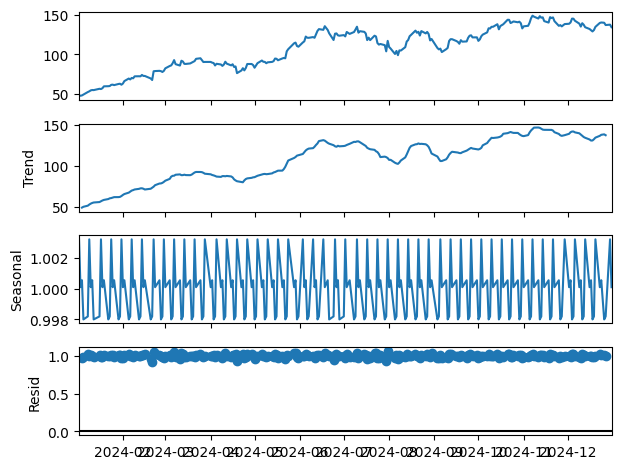

In [32]:
result = seasonal_decompose(data[['Close']], model='multiplicative', period=5)
result.plot()
plt.show()

From our residuals, we can see that this decomposition does a pretty good job at explaining our data!

A Trend-Seasonality decomposition is useful because it splits a complicated time series into simplier components that are easier to model and explain, thus allowing you to have more predictive power.

# **Modeling and Forecasting**

Let's model our data and make predictions. The two models we will explore are ARIMA and GARCH. These are very commonly used models in time series analysis.

An ARIMA model takes in 3 arguments: ARIMA$(p, d, q)$. Let's discuss what this acronym means.

## Autoregression

The AR in ARIMA stands for autoregressive. This is a component of an ARIMA model that describes the linear relationship between past values of the time series and the current value, hence the name. An AR model of order $p$ is of the form:

$$
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots
+ \phi_p Y_{t-p} + \epsilon_t
$$

where $\phi_1, \dots, \phi_p$ are real-valued coefficients and $\epsilon_t$ is an error term. This looks like a regression model of $Y_t$ as a function of the $p$ previous values of the time series.

## Moving Average

The MA in ARIMA stands for moving average. The MA component explains the current value of the series based on past forecast errors / residuals, rather than the values of the series itself. An MA model of order $q$ is of the form:

$$
Y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
$$

where $\mu$ is the mean of the time series (we are assuming stationarity here!), $\theta_1, \dots, \theta_q$ are real-valued coefficients and $\epsilon_t, \dots, \epsilon_{t-q}$ are residuals or error terms from previous values.

- Just as a reminder, residuals are the difference between the model's value and the true value at each time $t$

## ARIMA and SARIMA

ARIMA$(p, d, q)$ stands for autoregressive integrated moving average. It is a combination of the components we have discussed earlier:

$$
Y_t = \mu + \phi_1 Y_{t-1} + \dots
+ \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

SARIMA is just a generalization of an ARIMA model that accounts for seasonality. Once you specify $p$, $d$ and $q$, the ARIMA function will find the best values of the $\theta$'s and $\phi$'s using maximum likelihood estimation (MLE).

### Auto ARIMA

We want to automatically select the best values of $p$, $d$ and $q$. We can call a function called `auto_arima`, which runs through different values of these parameters for you and returns the "best" model.

If you are familiar with regression, the way that `auto_arima` works is that it trains different models with different values of $p$, $d$ and $q$ until it finds one that minimizes Akaike Information Criterion (AIC), which is very similar to how we chose the "best" regression model.

- You can specify a different criterion if you'd like
- The selected model may not always perform the best out-of-sample. You should still validate the model by checking residual diagnostics and out-of-sample forecasts.

Let's try this with our stock data. We already know that we have a seasonal period of about 5.

Order of ARIMA (p, d, q): (0, 1, 0)
Seasonal order (P, D, Q, m): (0, 0, 1, 5)
AIC: 1320.8851074640238


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


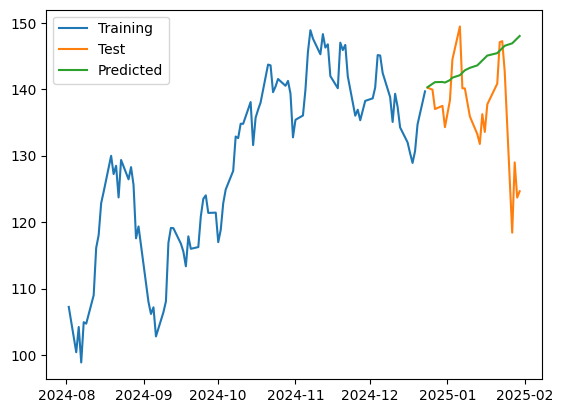

In [35]:
# split into training and testing data
train_data = data['Close'][:-24]
test_data = data['Close'][-24:]

# making the ARIMA model on the training data
seasonal_model = auto_arima(train_data, seasonal=True, m = 5)

# printing the order of ARIMA coefficients and the AIC
print("Order of ARIMA (p, d, q):", seasonal_model.order)
print("Seasonal order (P, D, Q, m):", seasonal_model.seasonal_order)
print("AIC:", seasonal_model.aic())

# forecasting
forecast = seasonal_model.predict(n_periods=24)

# plot
plt.plot(train_data[-100:], label="Training")
plt.plot(test_data, label="Test")
plt.plot(test_data.index, forecast, label='Predicted')
plt.legend(loc='upper left')
plt.show()

The green line is our out-of-sample prediction, and the orange line is the actual closing price. We're off to a good start! But, note that the orange line dramatically drops towards the end, which we have not accounted for. This happened when DeepSeek was introduced; we usually won't be able to predict when a large event like this will affect our data.

## GARCH

Notice that our model didn't do a very good job at capturing the high variance (volatility) of our data. This is because one of the assumptions of an ARIMA model was constant variance, and since we clearly do not have constant variance, our model is not great.

A GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is used to model the volatility of a time series with nonconstant variance. It is very useful for financial data. It is especially useful for modeling the clustering of volatility, where periods of high volatility are followed by high volatility, and periods of low volatility are followed by low volatility.

A GARCH$(p, q)$ model is a model for variance of the form
$$
\sigma^2_t = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon^2_{t-i} + \sum_{j=1}^p \beta_j \epsilon^2_{t-j}
$$
where $p$ and $q$ are different than the $p$ and $q$ for the ARIMA model (confusing, right?).

We can think of a GARCH model as modeling the $\epsilon_t$ component of the ARIMA equation:

$$
Y_t = \mu + \phi_1 Y_{t-1} + \dots
+ \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
$$
where $\text{Var}(\epsilon_t) = \sigma_t$. We are essentially getting rid of the assumption that the data has constant variance.

Let's add a GARCH component to our previous model to model the residuals:

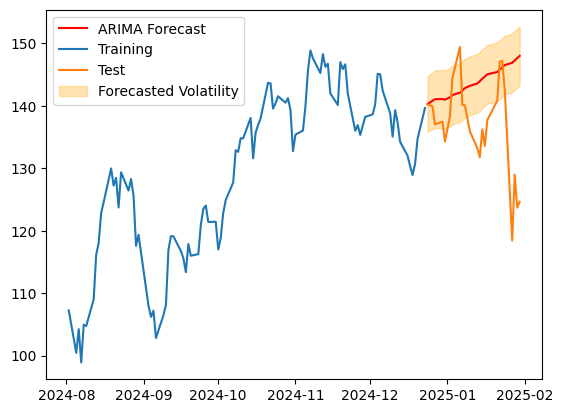

In [36]:
# extracting residuals from SARIMA model
residuals = seasonal_model.resid()

# GARCH model
garch_model = arch_model(residuals, vol='Garch', p=1, q=0)
garch_fit = garch_model.fit(disp="off")

# GARCH forecast
garch_forecast = garch_fit.forecast(horizon=24)
forecast_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# plot
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.plot(train_data[-100:], label="Training")
plt.plot(test_data, label="Test")

# fill in volatility estimates
plt.fill_between(test_data.index,
                 forecast - forecast_volatility,
                 forecast + forecast_volatility,
                 color='orange', alpha=0.3, label='Forecasted Volatility')

plt.legend(loc='upper left')
plt.show()

Now, the shaded yellow region better explains the volatility of our model and captures more of the data.

Notice that I picked the parameters for the GARCH model to be 1 and 0. How do you decide this? Usually, you try different values of $p$ and $q$ until you minimize AIC. GARCH(1, 0) and GARCH(1,1) are the most commonly used, because increasing the order severely increases the complexity of the model (it already takes a while to compile our code with $p = 1$ and $q = 0$, imagine how long it takes with higher order terms).

We can also use a GARCH model to model the volatility of transformed data to have more accurate predictions.

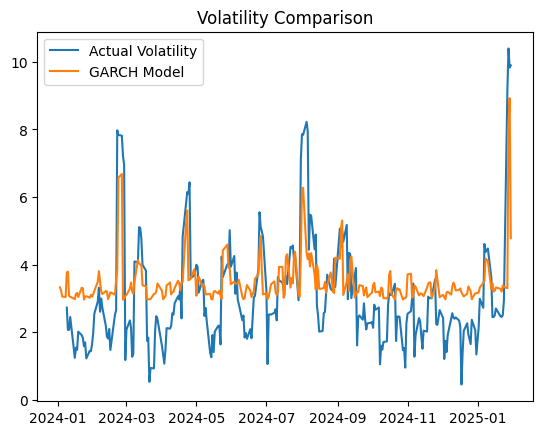

In [37]:
# we are scaling the returns here to avoid numerical errors
data[['Log_Close']] = np.log(data[['Close']])
data[['Log_Returns']] = data[['Log_Close']].diff().dropna()

returns = data[['Log_Returns']].dropna()

scaled_returns = returns * 100

garch_model = arch_model(scaled_returns, vol='Garch', p=2, q=1, mean='Constant')
garch_result = garch_model.fit(disp="off")

garch_volatility = garch_result.conditional_volatility
volatility = scaled_returns.rolling(window=5).std()


plt.plot(volatility, label="Actual Volatility")
plt.plot(garch_volatility, label="GARCH Model")
plt.title("Volatility Comparison")
plt.legend()
plt.show()
